In [3]:
##########################################
# Size Portfolio for CRSP Securities     #
# July 2018                              #                        
# Qingyi (Freda) Song Drechsler          #
##########################################

import pandas as pd
import numpy as np
import datetime as dt
import wrds
from dateutil.relativedelta import *

In [4]:
###################
# Connect to WRDS #
###################
conn = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
Loading library list...
Done


In [5]:
################################################
# Get CRSP Monthly Stocks for Decile Formation #
################################################
msf = conn.raw_sql("""
                      select a.permno, a.date, 
                      a.ret, a.shrout, a.prc 
                      from crsp.msf as a
                      where a.date >= '12/01/1999'
                      """, date_cols=['date'])

# keep only records with non missing ret prc and shrout value
msf = msf[(msf['prc'].notna()) & (msf['ret'].notna()) & (msf['shrout'].notna())]

msf['permno'] = msf['permno'].astype(int)
## How to compute size
msf['size'] = msf['shrout'] * msf['prc'].abs()
msf['year'] = msf['date'].dt.year
msf['month'] = msf['date'].dt.month

# create msf_dec
msf_dec = msf[msf['month']==12][['date','permno','year','size']]

# create msf_ls
msf_ls = msf.sort_values(['permno', 'date'])
msf_ls['year_prev'] = msf_ls['year']-1
msf_ls['size_lag'] = msf_ls.groupby('permno')['size'].shift(1)
msf_ls['size_lag'] = np.where(msf_ls['size_lag'].isna(),\
 msf_ls['size']/(1+msf_ls['ret']), msf_ls['size_lag'])

In [23]:
msf_ls.head()

,permno,date,ret,shrout,prc,size,year,month,year_prev,size_lag
0,10001,1999-12-31,-0.004188,2450.0,-8.50000,20825.00,1999,12,1998,20912.576138
8639,10001,2000-01-31,-0.044118,2450.0,8.12500,19906.25,2000,1,1999,20825.000000
17273,10001,2000-02-29,0.015385,2450.0,8.25000,20212.50,2000,2,1999,19906.250000
25924,10001,2000-03-31,-0.015758,2464.0,-8.00000,19712.00,2000,3,1999,20212.500000
34569,10001,2000-04-28,0.011719,2464.0,-8.09375,19943.00,2000,4,1999,19712.000000


In [7]:
msf_dec.head(100)

,date,permno,year,size
0,1999-12-31,10001,1999,2.082500e+04
1,1999-12-31,10002,1999,9.419719e+04
2,1999-12-31,10009,1999,3.402825e+04
3,1999-12-31,10012,1999,1.547943e+05
4,1999-12-31,10016,1999,3.372774e+05
...,...,...,...,...
97,1999-12-31,10375,1999,2.063381e+06
98,1999-12-31,10382,1999,3.595445e+05
99,1999-12-31,10383,1999,1.606828e+05
100,1999-12-31,10388,1999,1.698323e+05


In [9]:
#################################
# Compute Deciles for Each DEC  #
#################################
msf_dec = msf_dec.sort_values(['year'])
msf_dec['decile']=1+msf_dec.groupby('year')['size'].transform(lambda x: pd.qcut(x, 10, labels=False))

In [10]:
msf_dec.head(10)

,date,permno,year,size,decile
0,1999-12-31,10001,1999,2.082500e+04,2
5733,1999-12-31,83396,1999,6.006725e+04,4
5732,1999-12-31,83395,1999,1.304962e+04,1
5731,1999-12-31,83392,1999,7.661232e+06,10
5730,1999-12-31,83391,1999,9.114188e+03,1
5729,1999-12-31,83390,1999,2.224294e+04,2
5728,1999-12-31,83388,1999,5.799150e+04,4
5727,1999-12-31,83387,1999,5.375000e+03,1
5726,1999-12-31,83386,1999,1.499998e+07,10
5725,1999-12-31,83383,1999,5.028375e+04,3


In [22]:
msf_dec.groupby(['year','decile'])['size'].describe()

count          mean           std           min           25%  \
year decile                                                                  
1999 1       831.0  7.716727e+03  3.565929e+03  4.250000e+01  4.659375e+03   
     2       830.0  2.124447e+04  4.500390e+03  1.386984e+04  1.718428e+04   
     3       830.0  4.034458e+04  6.777234e+03  2.945850e+04  3.423727e+04   
     4       830.0  6.798131e+04  9.491155e+03  5.260250e+04  5.962975e+04   
     5       830.0  1.100184e+05  1.608225e+04  8.527975e+04  9.604455e+04   
...            ...           ...           ...           ...           ...   
2022 6       944.0  3.783164e+05  6.436256e+04  2.804108e+05  3.213105e+05   
     7       944.0  7.388625e+05  1.529800e+05  5.056441e+05  6.014231e+05   
     8       944.0  1.615853e+06  3.934828e+05  1.048846e+06  1.278042e+06   
     9       944.0  4.240732e+06  1.337285e+06  2.416918e+06  3.057473e+06   
     10      944.0  4.690149e+07  1.121016e+08  7.323958e+06  1.148666e+07   

                      50%           75%           max  
year decile                                            
1999 1       7.708000e+03  1.074362e+04  1.385888e+04  
     2       2.115623e+04  2.508212e+04  2.943750e+04  
     3       3.998150e+04  4.622550e+04  5.257600e+04  
     4       6.771475e+04  7.620291e+04  8.526975e+04  
     5       1.081069e+05  1.234460e+05  1.401502e+05  
...                   ...           ...           ...  
2022 6       3.711020e+05  4.265125e+05  5.051351e+05  
     7       7.210273e+05  8.664939e+05  1.048435e+06  
     8       1.544396e+06  1.938721e+06  2.416518e+06  
     9       3.979647e+06  5.293156e+06  7.302034e+06  
     10      1.994470e+07  4.087900e+07  2.066942e+09  

[240 rows x 8 columns]

In [24]:
###################################
# Assign Size Group to All Months #
###################################
msf_groups = pd.merge(msf_ls[['permno','date','ret','size_lag','year_prev']], \
                      msf_dec[['permno','year','decile']], how='left', \
                      left_on=['permno','year_prev'], right_on=['permno','year'])

msf_groups=msf_groups[msf_groups['decile'].notna()]

In [25]:
msf_groups.head(20)

,permno,date,ret,size_lag,year_prev,year,decile
1,10001,2000-01-31,-0.044118,20825.000000,1999,1999.0,2.0
2,10001,2000-02-29,0.015385,19906.250000,1999,1999.0,2.0
3,10001,2000-03-31,-0.015758,20212.500000,1999,1999.0,2.0
4,10001,2000-04-28,0.011719,19712.000000,1999,1999.0,2.0
5,10001,2000-05-31,-0.023166,19943.000000,1999,1999.0,2.0
6,10001,2000-06-30,0.027668,19481.000000,1999,1999.0,2.0
7,10001,2000-07-31,-0.015625,19800.000000,1999,1999.0,2.0
8,10001,2000-08-31,0.047619,19490.625000,1999,1999.0,2.0
9,10001,2000-09-29,0.075758,20418.750000,1999,1999.0,2.0
10,10001,2000-10-31,0.028571,21840.000000,1999,1999.0,2.0


In [26]:
#################################
# Compute Size Weighted Returns #
#################################
msf_groups = msf_groups.sort_values(['decile', 'date'])

# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

# value-weigthed return
vwrets=msf_groups.groupby(['decile','date']).apply(wavg, 'ret','size_lag')\
.to_frame().reset_index().rename(columns={0: 'vwret'})

In [27]:
vwrets.head(20)

,decile,date,vwret
0,1.0,2000-01-31,0.222623
1,1.0,2000-02-29,0.246672
2,1.0,2000-03-31,-0.024419
3,1.0,2000-04-28,-0.175907
4,1.0,2000-05-31,-0.093232
5,1.0,2000-06-30,0.051372
6,1.0,2000-07-31,-0.031004
7,1.0,2000-08-31,0.054793
8,1.0,2000-09-29,-0.041949
9,1.0,2000-10-31,-0.104683


In [15]:
################################## 
# Compare Results with CRSP MSIX #
##################################
msix = conn.raw_sql("""
                      select caldt, decret1, decret2, decret3, decret4, decret5,
                      decret6, decret7, decret8, decret9, decret10
                      from crsp.msix where caldt >= '12/01/1999'
                      """, date_cols=['caldt']) 

# transpose msix data
msix1=pd.melt(msix, id_vars='caldt', \
              value_vars=['decret1','decret2', 'decret3', 'decret4', 'decret5', 'decret6', \
'decret7', 'decret8','decret9','decret10'])

# extract decile information from decret
msix1['decile'] = msix1['variable'].str[6:].astype(int)
# rename return column
msix1 = msix1.rename(columns={'value':'decret', 'caldt':'date'})
msix1 = msix1.drop(['variable'], axis=1)

decile_returns = pd.merge(vwrets, msix1, how='left', on=['date','decile'])

###################
# End of Program  #
###################

In [16]:
decile_returns.head()

,decile,date,vwret,decret
0,1.0,2000-01-31,0.222626,0.207740
1,1.0,2000-02-29,0.246672,0.240418
2,1.0,2000-03-31,-0.024419,-0.027778
3,1.0,2000-04-28,-0.175907,-0.170390
4,1.0,2000-05-31,-0.093232,-0.087108


In [17]:
####################
# Visualization    #
####################

# Plotting the returns by decile
import os
import matplotlib.pyplot as plt
%matplotlib inline

df = decile_returns
df1 = df[df['decile']==1]
df2 = df[df['decile']==2]
df3 = df[df['decile']==3]
df4 = df[df['decile']==4]
df5 = df[df['decile']==5]
df6 = df[df['decile']==6]
df7 = df[df['decile']==7]
df8 = df[df['decile']==8]
df9 = df[df['decile']==9]
df10 = df[df['decile']==10]

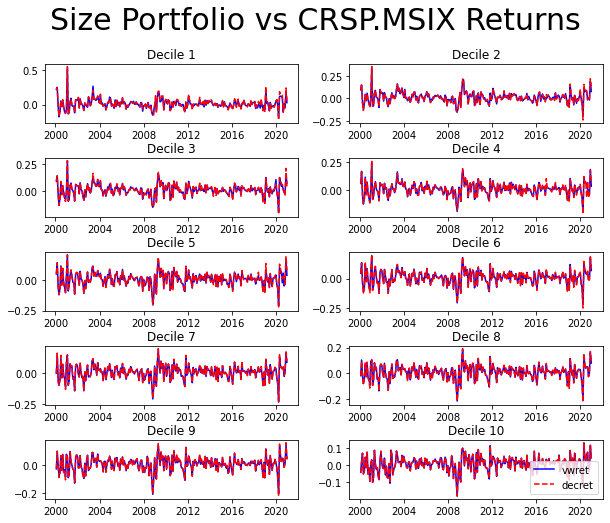

In [18]:
fig = plt.figure(figsize=(10,8))
fig.subplots_adjust(hspace=.6)
plt.suptitle('Size Portfolio vs CRSP.MSIX Returns', fontsize=30)

plt.subplot(521)
plt.plot(df1['date'], df1['vwret'], 'b', df1['date'], df1['decret'], 'r--')
plt.title('Decile 1')

plt.subplot(522)
plt.plot(df2['date'], df2['vwret'], 'b', df2['date'], df2['decret'], 'r--')
plt.title('Decile 2')

plt.subplot(523)
plt.plot(df3['date'], df3['vwret'], 'b', df3['date'], df3['decret'], 'r--')
plt.title('Decile 3')

plt.subplot(524)
plt.plot(df4['date'], df4['vwret'], 'b', df4['date'], df4['decret'], 'r--')
plt.title('Decile 4')

plt.subplot(525)
plt.plot(df5['date'], df5['vwret'], 'b', df5['date'], df5['decret'], 'r--')
plt.title('Decile 5')

plt.subplot(526)
plt.plot(df6['date'], df6['vwret'], 'b', df6['date'], df6['decret'], 'r--')
plt.title('Decile 6')

plt.subplot(527)
plt.plot(df7['date'], df7['vwret'], 'b', df7['date'], df7['decret'], 'r--')
plt.title('Decile 7')

plt.subplot(528)
plt.plot(df8['date'], df8['vwret'], 'b', df8['date'], df8['decret'], 'r--')
plt.title('Decile 8')

plt.subplot(529)
plt.plot(df9['date'], df9['vwret'], 'b', df9['date'], df9['decret'], 'r--')
plt.title('Decile 9')

plt.subplot(5,2,10)
plt.plot(df10['date'], df10['vwret'], 'b', df10['date'], df10['decret'], 'r--')
plt.title('Decile 10')

plt.legend(['vwret', 'decret'])
plt.show()

#uncomment and edit these lines to save the png output
#from pathlib import Path
#fig.savefig(os.path.join(Path.home(), '<your_subdirectory>', 'size_port_return.png'))
